# Thorpe scale approach in the Weddell Sea

### Import necessary packages

In [1]:
#for data read in, only pandas is necessary
import numpy as np
import pandas as pd
import datetime

# further work with the data may require (amongst others)
import numpy as np
import scipy.signal as signal
import scipy.io as sio
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.facecolor":  "white",  
    "savefig.facecolor": "white",  
    "figure.figsize": [8,6]
})
import matplotlib.colors as mcolors
import cmocean

import gsw #Gibbs Seawater Toolbox https://github.com/TEOS-10/GSW-Python

from location import Location
import helper_functions as helper

In [2]:
def generate_colors(num_colors, colormap_name):
    colormap = plt.cm.get_cmap(colormap_name, num_colors)
    colors = [colormap(i) for i in range(num_colors)]
    return colors

In [3]:
def smooth(array,length):
    window = signal.windows.hann(length)  # construct Hanning window
    smoothed = signal.convolve(array, window, mode="same") / np.sum(window)  # smooth by convolving speed with window
    return smoothed

# Get CTD Data

In [4]:
columns = ['Event', 'Date/Time', 'Latitude', 'Longitude',
       'Depth water [m]', 'Press [dbar]', 'Temp [°C]', 'Sal', 'Expedition']
CTDs = pd.DataFrame(columns=columns)

In [5]:
#definition of box around the transect 
m = (63.21 - 64.22)/(53.8 - 47)
b = 63.21 - m * 53.8
shift = 0.12

In [6]:
def get_PS129_CTD_data():
    from location import Location
    from ctd_cast import CTDCast
    
    #get location of CTD files from the LADCP data files
    LADCP_DIRECTORY = f"/media/sf_VM_Folder/PS129_Plots/ladcp_profiles/"

    ladcp_paths = sorted(helper.IO.get_filepaths_from_directory(LADCP_DIRECTORY, inclusive = (".mat",)))

    #all CTD cast can be identified by a number
    ladcp_cast_numbers = [path.split('/')[-1][7:-4] for path in ladcp_paths]

    #create list of all CTD cast locations
    ctd_locations = []
    ctd_timestamps = []
    for path in ladcp_paths:
        data_struct = sio.loadmat(path) 
        data = data_struct["dr"][0][0]
        lat = np.round(np.squeeze(data["lat"]),3)
        lon = np.round(np.squeeze(data["lon"]),3)
        ctd_locations.append(Location(lat = lat, lon = lon))
        time_stamp = datetime.datetime(*map(int, np.squeeze(data["date"]))) #convert list of values to datetime object
        ctd_timestamps.append(time_stamp)
        
    # Set up conversion from ID number to cast name    
    def load_stations(path):
        transect_names, transect_numbers = np.loadtxt(path, dtype = (str), delimiter = "\t", unpack = True)
        translate = dict(zip(transect_names, transect_numbers))
        #print(translate)
        return translate
    name_to_number_dict = load_stations("/media/sf_VM_Folder/PS129_Plots/conversion.txt")
    number_to_name_dict = {int(v): k for k, v in name_to_number_dict.items()}    

    #create as many CTDCast objects as casts itself
    list_of_PS129_casts= [CTDCast() for _ in ladcp_cast_numbers]

    # for every cast object set a location and a name
    for i,cast in enumerate(list_of_PS129_casts):
        cast_number = ladcp_cast_numbers[i]
        cast_name = number_to_name_dict[int(cast_number)]
        cast.name = cast_name
        cast.location = ctd_locations[i]
        cast.date = ctd_timestamps[i]

    column_names = ['Event', "Latitude", "Longitude", "Press [dbar]", "Sal", "Temp [°C]", "Absolute Salinity", "Conservative Temperature", "Date/Time", "Depth water [m]", "Expedition"]
    data_dict = {name:[] for name in column_names}

    for cast in list_of_PS129_casts:
        #load actual data to that Cast name
        try:   
            path = f"/media/sf_VM_Folder/PS129_Plots/ctd_profiles/dps129_{cast.name}.cnv"
        
            #SP = Practical Salinity [PSU]
            #Temperature [ITS-90, °C]

            #add the cast data to the data dictionary
            pressure,in_situ_temperature,practical_salinity = np.genfromtxt(path, skip_header = 322, usecols = (0,1,5), unpack = True)
            data_dict["Event"].extend([f"PS129_{cast.name}"] * len(pressure))
            data_dict["Latitude"].extend([cast.location.lat] * len(pressure))
            data_dict["Longitude"].extend([cast.location.lon] * len(pressure))
            data_dict["Press [dbar]"].extend(pressure)
            data_dict["Temp [°C]"].extend(in_situ_temperature)
            data_dict["Sal"].extend(practical_salinity)
            data_dict["Date/Time"].extend([cast.date] * len(pressure))
            data_dict["Expedition"].extend(["PS129"] * len(pressure))
            
            #add new attributes
            SA = gsw.SA_from_SP(SP = practical_salinity, p = pressure, lon = cast.location.lon, lat = cast.location.lat)
            data_dict["Absolute Salinity"].extend(SA)
            data_dict["Conservative Temperature"].extend(gsw.CT_from_t(SA = SA, t = in_situ_temperature, p = pressure))
            data_dict["Depth water [m]"].extend(np.abs(gsw.z_from_p(p = pressure, lat = cast.location.lat)))
        
        except ValueError as e:
            print("Error at ",cast.name, cast.location)
            print(e)
            continue
        #print(cast.name)     
    #print(data_dict)
    for (k,v) in data_dict.items():
        print(k,len(v))
    return pd.DataFrame(data = data_dict)

In [7]:
PS129_CTDs = get_PS129_CTD_data()
CTDs = CTDs.merge(PS129_CTDs, on = columns, how = "outer")
#Drop all rows that are not even close to the moorings
CTDs.drop(CTDs[CTDs.Latitude < -64.5].index, inplace = True)
CTDs.drop(CTDs[CTDs.Latitude > -63].index, inplace = True)
CTDs.drop(CTDs[CTDs.Longitude < -54].index, inplace = True)
CTDs.drop(CTDs[CTDs.Longitude > -47].index, inplace = True)

CTDs.drop(CTDs[
    m*CTDs.Longitude-b+shift < CTDs.Latitude
].index, inplace = True)

CTDs.drop(CTDs[
    m*CTDs.Longitude-b-shift > CTDs.Latitude 
].index, inplace = True)

CTDs.reset_index(inplace = True, drop=True)
    
CTDs

Error at  018_07 (-59.09,0.12)
Some errors were detected !
    Line #323 (got 1 columns instead of 3)
Event 135941
Latitude 135941
Longitude 135941
Press [dbar] 135941
Sal 135941
Temp [°C] 135941
Absolute Salinity 135941
Conservative Temperature 135941
Date/Time 135941
Depth water [m] 135941
Expedition 135941


,Event,Latitude,Longitude,Press [dbar],Sal,Temp [°C],Absolute Salinity,Conservative Temperature,Date/Time,Depth water [m],Expedition
0,PS129_102_01,-64.131,-47.953,1.0,33.8873,-1.8490,34.052925,-1.844905,2022-04-20 06:44:16,0.990258,PS129
1,PS129_102_01,-64.131,-47.953,2.0,33.8840,-1.8451,34.049596,-1.841016,2022-04-20 06:44:16,1.980511,PS129
2,PS129_102_01,-64.131,-47.953,3.0,33.8830,-1.8433,34.048579,-1.839230,2022-04-20 06:44:16,2.970760,PS129
3,PS129_102_01,-64.131,-47.953,4.0,33.8836,-1.8438,34.049169,-1.839748,2022-04-20 06:44:16,3.961003,PS129
4,PS129_102_01,-64.131,-47.953,5.0,33.8853,-1.8467,34.050865,-1.842667,2022-04-20 06:44:16,4.951242,PS129
...,...,...,...,...,...,...,...,...,...,...,...
35926,PS129_122_01,-63.168,-53.955,227.0,34.4466,-0.9783,34.615488,-0.981688,2022-04-23 21:39:39,224.681402,PS129
35927,PS129_122_01,-63.168,-53.955,228.0,34.4465,-0.9782,34.615391,-0.981618,2022-04-23 21:39:39,225.670642,PS129
35928,PS129_122_01,-63.168,-53.955,229.0,34.4466,-0.9782,34.615494,-0.981648,2022-04-23 21:39:39,226.659877,PS129
35929,PS129_122_01,-63.168,-53.955,230.0,34.4466,-0.9782,34.615497,-0.981678,2022-04-23 21:39:39,227.649108,PS129


In [8]:
def find_line_number(filename, target_string):
    with open(filename, 'r') as file:
        for line_number, line in enumerate(file):
            if line.startswith(target_string):
                return line_number
    return None

In [9]:
data_paths = helper.IO.get_filepaths_from_directory(directory = "/media/sf_VM_Folder/data/CTD", inclusive = ".tab", exclusive = ())
for p in data_paths: print(p)

/media/sf_VM_Folder/data/CTD/ANT-IX_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-VIII_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XIII_4_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XIV_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XV_4_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXII_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIV_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIX_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIX_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIX_6_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXVII_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-X_4_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-X_7_phys_oce.tab
/media/sf_VM_Folder/data/CTD/PS103_phys_oce.tab
/media/sf_VM_Folder/data/CTD/PS117_phys_oce.tab


PS18 /media/sf_VM_Folder/data/CTD/ANT-IX_2_phys_oce.tab
PS16 /media/sf_VM_Folder/data/CTD/ANT-VIII_2_phys_oce.tab
PS40 /media/sf_VM_Folder/data/CTD/ANT-XIII_4_phys_oce.tab
!! Error loading /media/sf_VM_Folder/data/CTD/ANT-XIV_3_phys_oce.tab
single positional indexer is out-of-bounds
PS49 /media/sf_VM_Folder/data/CTD/ANT-XV_4_phys_oce.tab
PS67 /media/sf_VM_Folder/data/CTD/ANT-XXII_3_phys_oce.tab
PS71 /media/sf_VM_Folder/data/CTD/ANT-XXIV_3_phys_oce.tab
PS81 /media/sf_VM_Folder/data/CTD/ANT-XXIX_2_phys_oce.tab
!! Error loading /media/sf_VM_Folder/data/CTD/ANT-XXIX_3_phys_oce.tab
single positional indexer is out-of-bounds
PS81 /media/sf_VM_Folder/data/CTD/ANT-XXIX_6_phys_oce.tab
PS77 /media/sf_VM_Folder/data/CTD/ANT-XXVII_2_phys_oce.tab
!! Error loading /media/sf_VM_Folder/data/CTD/ANT-X_4_phys_oce.tab
single positional indexer is out-of-bounds
PS23 /media/sf_VM_Folder/data/CTD/ANT-X_7_phys_oce.tab
PS103 /media/sf_VM_Folder/data/CTD/PS103_phys_oce.tab
PS117 /media/sf_VM_Folder/data/CTD/PS

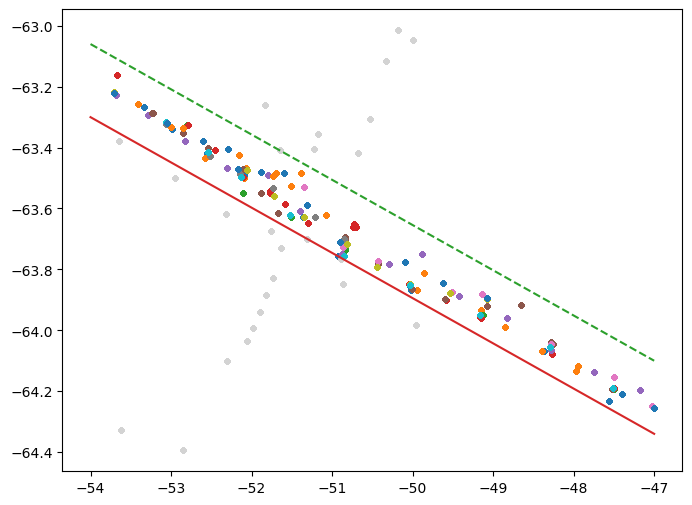

In [10]:
for i, path in enumerate(data_paths):
    target_string = "Event\tDate/Time\tLatitude\tLongitude\tElevation [m]"
    skiprows = find_line_number(path, target_string)
    if skiprows == None:
        target_string = "Event	Type	Date/Time	Longitude"
        skiprows = find_line_number(path, target_string)

    data = pd.read_csv(path, delimiter = "\t", skiprows= skiprows)
    
    data = data[data.columns.intersection(columns)]
    
    #Drop all rows that are not even close to the moorings
    data.drop(data[data.Latitude < -64.5].index, inplace = True)
    data.drop(data[data.Latitude > -63].index, inplace = True)
    data.drop(data[data.Longitude < -54].index, inplace = True)
    data.drop(data[data.Longitude > -47].index, inplace = True)
  
    plt.plot(data.Longitude,data.Latitude, ".", color = "lightgrey")

    data.drop(data[
        m*data.Longitude-b+shift < data.Latitude
    ].index, inplace = True)
    
    data.drop(data[
        m*data.Longitude-b-shift > data.Latitude 
    ].index, inplace = True)
            
    data.reset_index(inplace = True, drop=True)
    
    data['Date/Time'] =  pd.to_datetime(data['Date/Time'])#, format='%d%b%Y:%H:%M:%S.%f')
    data['Event'] = data['Event'].astype('category')
    
    try:
        if data['Event'].iloc[0][4] != "/": 
            current_expedition = data['Event'].iloc[0][0:5]
        else:
            current_expedition = data['Event'].iloc[0][0:4]
        print(current_expedition, path)
        data['Expedition'] = current_expedition
        plt.plot(data.Longitude,data.Latitude, ".", label = path.split("/")[-1])
        CTDs = CTDs.merge(data, on = columns, how = "outer")  
        assert not data.empty
    
    except IndexError as e:
        print(f"!! Error loading {path}")
        print(e)
        assert data.empty
        continue

        
CTDs['Event'] = CTDs['Event'].astype('category')    
CTDs['Expedition'] = CTDs['Expedition'].astype('category')  
CTDs = CTDs.copy() #may prevent memory fragmentation created by merging data frames
x = np.linspace(-54,-47,4)
plt.plot(x,m*x-b+shift,"--")    
plt.plot(x,m*x-b-shift) 

#plt.legend()    

In [11]:
CTDs

,Event,Latitude,Longitude,Press [dbar],Sal,Temp [°C],Absolute Salinity,Conservative Temperature,Date/Time,Depth water [m],Expedition
0,PS129_102_01,-64.1310,-47.9530,1.0,33.8873,-1.8490,34.052925,-1.844905,2022-04-20 06:44:16,0.990258,PS129
1,PS129_102_01,-64.1310,-47.9530,2.0,33.8840,-1.8451,34.049596,-1.841016,2022-04-20 06:44:16,1.980511,PS129
2,PS129_102_01,-64.1310,-47.9530,3.0,33.8830,-1.8433,34.048579,-1.839230,2022-04-20 06:44:16,2.970760,PS129
3,PS129_102_01,-64.1310,-47.9530,4.0,33.8836,-1.8438,34.049169,-1.839748,2022-04-20 06:44:16,3.961003,PS129
4,PS129_102_01,-64.1310,-47.9530,5.0,33.8853,-1.8467,34.050865,-1.842667,2022-04-20 06:44:16,4.951242,PS129
...,...,...,...,...,...,...,...,...,...,...,...
281749,PS117_93-1,-63.2557,-53.4054,381.0,34.5890,-0.8440,NaN,NaN,2019-01-31 22:21:00,377.000000,PS117
281750,PS117_93-1,-63.2557,-53.4054,382.0,34.5890,-0.8431,NaN,NaN,2019-01-31 22:21:00,378.000000,PS117
281751,PS117_93-1,-63.2557,-53.4054,383.0,34.5891,-0.8413,NaN,NaN,2019-01-31 22:21:00,378.900000,PS117
281752,PS117_93-1,-63.2557,-53.4054,384.0,34.5895,-0.8390,NaN,NaN,2019-01-31 22:21:00,379.900000,PS117


In [12]:
CTDs_grouped = CTDs.groupby("Expedition")
expedition_names = CTDs_grouped.groups.keys()
print(expedition_names)

dict_keys(['PS103', 'PS117', 'PS129', 'PS16', 'PS18', 'PS23', 'PS40', 'PS49', 'PS67', 'PS71', 'PS77', 'PS81'])


# MixSea on an example profile 

In [13]:
import mixsea as mx

In [14]:
event = "PS16/153-1"
profile = CTDs.groupby("Event").get_group(event).reset_index(drop = True)
profile

,Event,Latitude,Longitude,Press [dbar],Sal,Temp [°C],Absolute Salinity,Conservative Temperature,Date/Time,Depth water [m],Expedition
0,PS16/153-1,-63.9333,-49.15,10.0,34.4255,-1.8555,NaN,NaN,1989-09-15 02:11:00,9.9,PS16
1,PS16/153-1,-63.9333,-49.15,12.0,34.4263,-1.8560,NaN,NaN,1989-09-15 02:11:00,11.9,PS16
2,PS16/153-1,-63.9333,-49.15,14.0,34.4274,-1.8617,NaN,NaN,1989-09-15 02:11:00,13.9,PS16
3,PS16/153-1,-63.9333,-49.15,16.0,34.4267,-1.8620,NaN,NaN,1989-09-15 02:11:00,15.8,PS16
4,PS16/153-1,-63.9333,-49.15,18.0,34.4266,-1.8619,NaN,NaN,1989-09-15 02:11:00,17.8,PS16
...,...,...,...,...,...,...,...,...,...,...,...
1756,PS16/153-1,-63.9333,-49.15,3522.0,34.6232,-0.8569,NaN,NaN,1989-09-15 02:11:00,3458.9,PS16
1757,PS16/153-1,-63.9333,-49.15,3524.0,34.6229,-0.8658,NaN,NaN,1989-09-15 02:11:00,3460.9,PS16
1758,PS16/153-1,-63.9333,-49.15,3526.0,34.6232,-0.8715,NaN,NaN,1989-09-15 02:11:00,3462.8,PS16
1759,PS16/153-1,-63.9333,-49.15,3528.0,34.6230,-0.8714,NaN,NaN,1989-09-15 02:11:00,3464.8,PS16


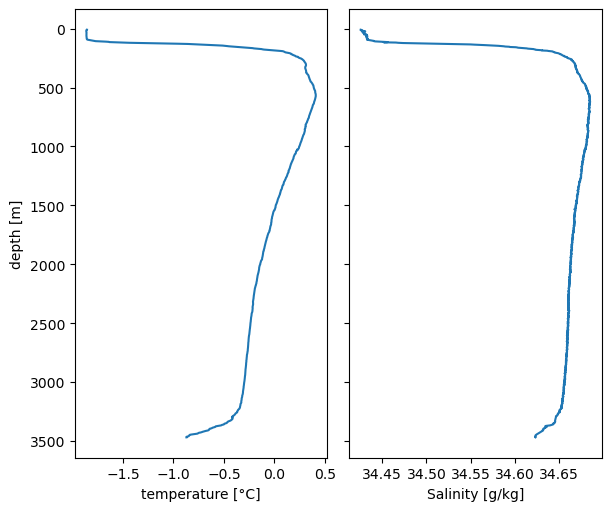

In [15]:
fig, ax = plt.subplots(nrows=1,
                           ncols=2,
                           figsize=(6, 5),
                           constrained_layout=True,
                           sharey=True)

ax[0].plot(profile['Temp [°C]'], profile['Depth water [m]'])
ax[1].plot(profile['Sal'], profile['Depth water [m]'])
ax[0].set(ylabel='depth [m]', xlabel='temperature [°C]')
ax[1].set_xlabel("Salinity [g/kg]")
ax[0].invert_yaxis()

## Thorpe Scales / Overturns

**A note about NaN values:** A common practise when compiling observational data from ctd casts is to pad the top and/or bottom of profiles with NaN. This allows for convenient storage of many different length profiles in one 2D array. However, it also means we must constantly think about how to deal with NaN values in our data. `mixsea` contains a version of the Thorpe scale method that attempts to deal with NaN values in the most simple way possible, that is, it removes them before doing any calculations and then adds them back at the end. In many cases, such a simple approach will not be appropriate and could lead to erroneous results. As such, we highly recommend performing a quality control of your data prior to Thorpe scale analysis. In the example below we use `nan_eps_overturn` because our test data contain NaNs. If your data do not, then it is better to use `eps_overturn` directly.

In [16]:
DENSITY_NOISE = 1e-4  # Noise parameter, Default value = 5e-4  
ALPHA = 0.8  # Coefficient relating the Thorpe and Ozmidov scales.
# Background value of epsilon applied where no overturns are detected.
background_eps = 1e-10 #np.nan

eps, N2_in_radians = mx.overturn.eps_overturn(
    profile['Depth water [m]'],
    profile['Temp [°C]'],
    profile['Sal'],
    profile["Longitude"].mean(),
    profile["Latitude"].mean(),
    dnoise=DENSITY_NOISE,
    alpha=ALPHA,
    background_eps=background_eps,
    use_ip= False
)

## Let's take a look at the results, zooming in on the bottom 200 m of the profile.

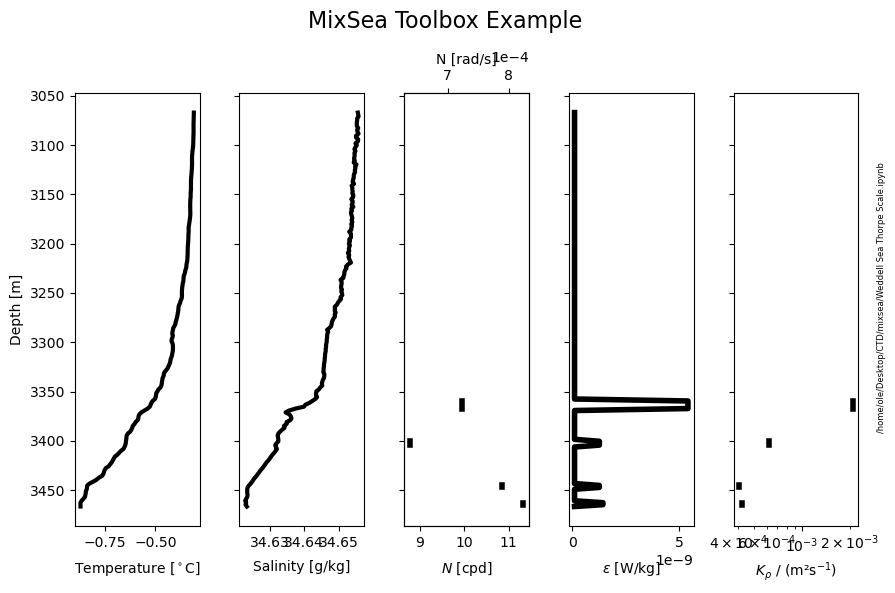

In [17]:
# Calculate buoyancy frequency in rad/s in units of cycles per day (cpd).
N = np.sqrt(N2_in_radians) * (86400 / (2 * np.pi))  

# Plot only in the depth range:
max_depth = profile['Depth water [m]'].max()
cut = profile['Depth water [m]'] > ( max_depth - 400 )
depth = profile['Depth water [m]'][cut]

# Alternative calculation of N with the gsw package
#calculate square of buoyancy frequency    
cont_N2, cont_N2pressure = gsw.Nsquared(
    SA = profile["Absolute Salinity"],
    CT = profile["Conservative Temperature"],
    p = profile["Press [dbar]"],
    lat = profile["Latitude"])
cont_depth = -1*gsw.z_from_p(p = cont_N2pressure, lat = profile["Latitude"].mean()) 
cont_N2 = smooth(cont_N2,8)
cont_N = np.sqrt(cont_N2)*86400 / (2*np.pi) #Conversion from rad/s to to cpd
cont_cut = cont_depth > ( np.max(cont_depth) - 400 )

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(9, 6))
axs[0].plot(profile['Temp [°C]'][cut], depth,"k", lw =3)
axs[1].plot(profile['Sal'][cut], depth,"k", lw =3)
axs[2].plot(N[cut], depth, "k", lw = 4)
axs[2].plot(cont_N[cont_cut], cont_depth[cont_cut], c = "grey", lw = 2, alpha = 0.6, zorder = -1)  

CPDtoRads = 2*np.pi/86400

ax_Hz = axs[2].twiny()
l, r = axs[2].get_xlim()
ax_Hz.set_xlim(l*CPDtoRads, r*CPDtoRads)
ax_Hz.set_xlabel('N [rad/s]')
ax_Hz.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

axs[3].plot(eps[cut], depth, "k", lw = 4)
axs[4].semilogx(0.2 * eps[cut] / N2_in_radians[cut], depth,"k", lw = 4)

axs[0].invert_yaxis()
axs[0].set_ylabel("Depth [m]")
axs[2].set_xlabel(r"$N$ [cpd]")
axs[3].set_xlabel(r"$\epsilon$ [W/kg]")
axs[4].set_xlabel(r"$K_\rho$ / (m²s$^{-1}$)")
axs[0].set_xlabel(r"Temperature [$^\circ$C]")
axs[1].set_xlabel("Salinity [g/kg]")
fig.align_labels()

fig.suptitle('MixSea Toolbox Example', fontsize=16)
helper.Plot.path_as_footnote(fig = fig, 
                             path = "/home/ole/Desktop/CTD/mixsea/Weddell Sea Thorpe Scale.ipynb", 
                             rot = "vertical")
fig.tight_layout()
fig.savefig("./MixSeaExample.png", dpi = 300)

# Iterate over Noise values to find a usable value

/tmp/ipykernel_13540/3998218230.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(colormap_name, num_colors)


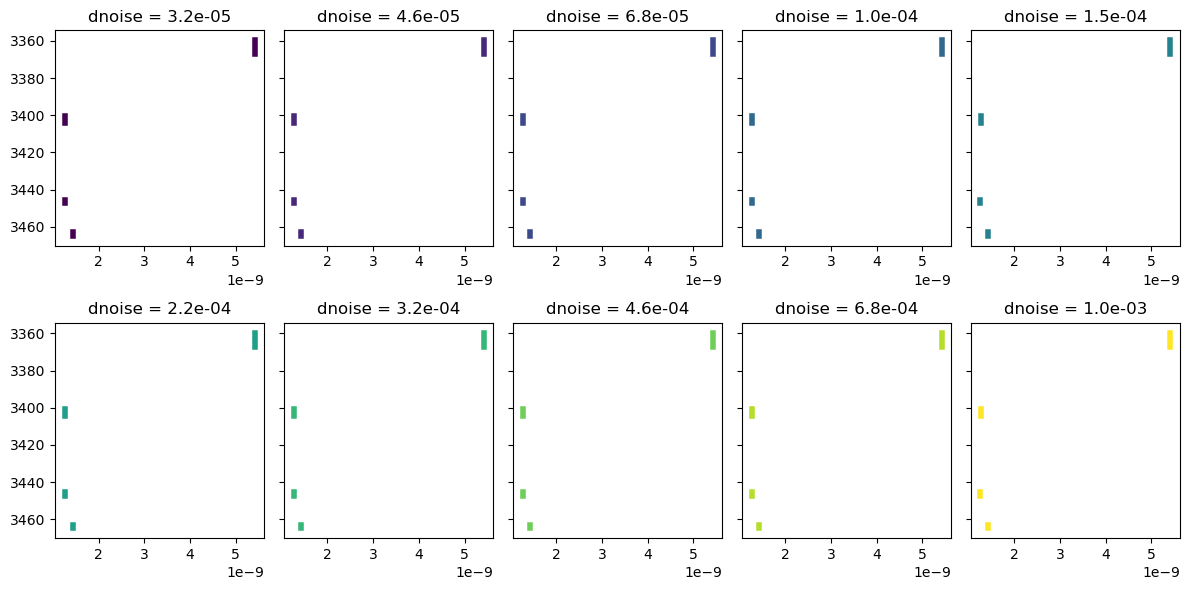

In [18]:
fig, axs = plt.subplots(ncols = 5, nrows = 2, sharey = True, figsize=(12, 6))

colors = generate_colors(10, "viridis")


for ax,dnoise, color in zip(axs.flatten(),np.logspace(-4.5,-3,10),colors):
    alpha = 0.95  # Coefficient relating the Thorpe and Ozmidov scales.
    background_eps = np.nan # Background value of epsilon

    eps, _N2 = mx.overturn.eps_overturn(
        profile['Depth water [m]'],
        profile['Temp [°C]'],
        profile['Sal'],
        profile["Longitude"].mean(),
        profile["Latitude"].mean(),
        dnoise=DENSITY_NOISE,
        alpha=ALPHA,
        background_eps=background_eps,
        use_ip = False
    )

    # Plot only in the depth range:
    max_depth = profile['Depth water [m]'].max()
    cut = profile['Depth water [m]'] > ( max_depth - 400 )
    depth = profile['Depth water [m]'][cut]

    ax.plot(eps[cut], depth, color = color, label = color, lw = 4)
    ax.set_title(f"{dnoise = :.1e}")

axs[0,0].invert_yaxis()
fig.tight_layout()

Various numbers look good, I decided to use $\mathrm{dnoise} = 3e^{-4}$ 

## Compare results from different dnoise values

/tmp/ipykernel_13540/3998218230.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(colormap_name, num_colors)


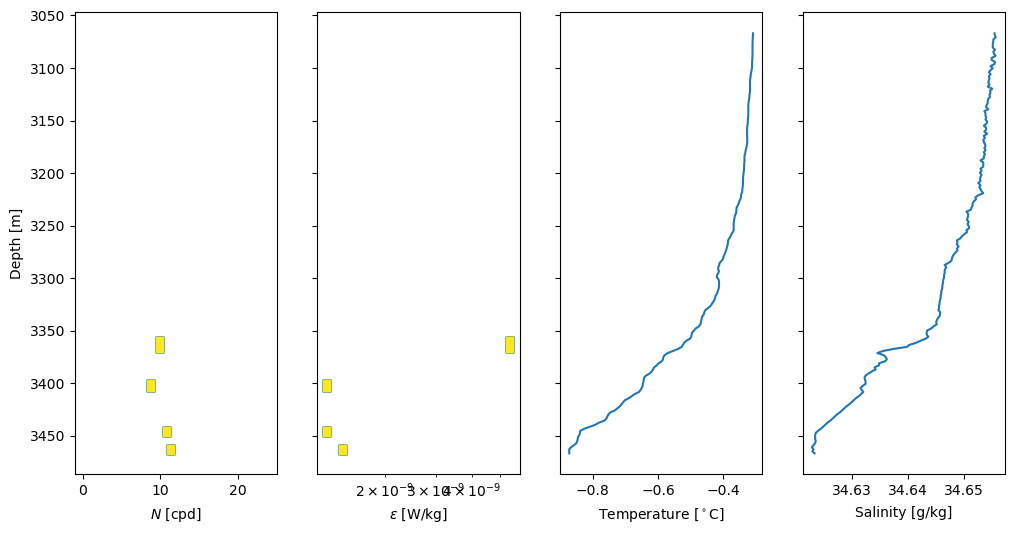

In [19]:
fig, axs = plt.subplots(ncols = 4, sharey = True, figsize=(12, 6))

colors = generate_colors(10, "viridis")


for dnoise, color in zip(np.logspace(-4.5,-3,10),colors):
    alpha = 0.95  # Coefficient relating the Thorpe and Ozmidov scales.
    # Background value of epsilon applied where no overturns are detected.
    background_eps = np.nan

    eps, N2_rad_per_second = mx.overturn.eps_overturn(
        profile['Depth water [m]'],
        profile['Temp [°C]'],
        profile['Sal'],
        profile["Longitude"].mean(),
        profile["Latitude"].mean(),
        dnoise=DENSITY_NOISE,
        alpha=ALPHA,
        background_eps=background_eps,
    )

    N = np.sqrt(N2_rad_per_second) * 86400 / (2 * np.pi)  # Calculate buoyancy frequency in units of cycles per day (cpd).

    # Plot only in the depth range:
    max_depth = profile['Depth water [m]'].max()
    cut = profile['Depth water [m]'] > ( max_depth - 400 )
    depth = profile['Depth water [m]'][cut]

    axs[0].plot(N[cut], depth, color = color, lw = 6)
    axs[1].semilogx(eps[cut], depth, color = color, lw =6)#, label = color)

#axs[1].legend()    
axs[0].set_xlim(-1,25)
#axs[1].set_xlim(-1e-9,1e-8)
#axs[1].legend()  
axs[2].plot(profile['Temp [°C]'][cut], depth)
axs[3].plot(profile['Sal'][cut], depth)
axs[0].invert_yaxis()
axs[0].set_ylabel("Depth [m]")
axs[0].set_xlabel(r"$N$ [cpd]")
axs[1].set_xlabel(r"$\epsilon$ [W/kg]")
axs[2].set_xlabel(r"Temperature [$^\circ$C]")
axs[3].set_xlabel("Salinity [g/kg]")
fig.align_labels()

# Apply Overturn analysis to all profiles

In [20]:
dnoise = 3e-4  # Density Noise parameter
alpha = 0.95  # Coefficient relating the Thorpe and Ozmidov scales.
# Background value of epsilon applied where no overturns are detected.
background_eps = np.nan

In [60]:
CTDs_grouped = CTDs.groupby("Event")
events = CTDs_grouped.groups.keys()

PS117_66-4 is too shallow
PS18/045-2 shows 0.49 °C at the bottom, which is too high 
PS23/061-1 only produces NaNs
PS40/098-1 only produces NaNs
PS40/099-1 only produces NaNs
PS40/099-4 only produces NaNs
PS40/100-1 only produces NaNs
PS40/101-1 only produces NaNs
PS40/102-2 only produces NaNs
PS49/015-2 shows 0.66 °C at the bottom, which is too high 
PS49/017-1 only produces NaNs
PS71/209-1 only produces NaNs
PS71/210-1 is too shallow
PS71/210-2 is too shallow
PS71/210-2 shows 0.27 °C at the bottom, which is too high 
PS71/212-3 shows 0.49 °C at the bottom, which is too high 
PS81/101-1 only produces NaNs
PS81/102-1 only produces NaNs


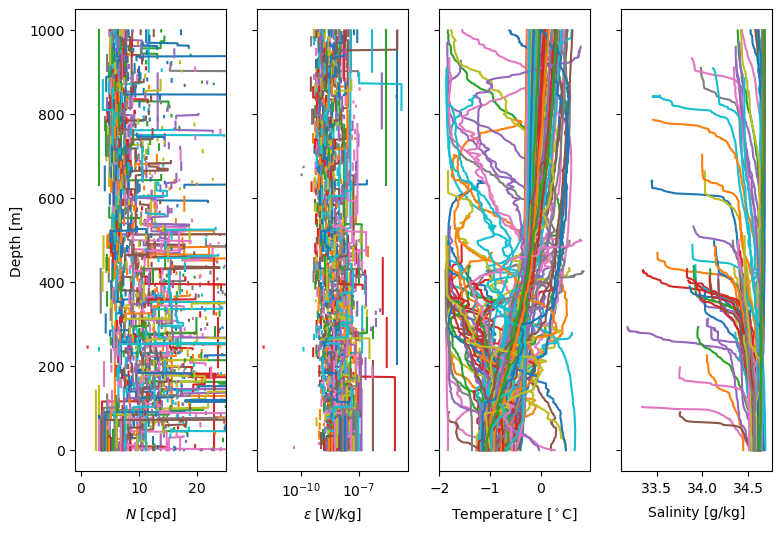

In [61]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(9, 6))


for event in events:
    current_profile = CTDs_grouped.get_group(event).reset_index(drop = True)

    #print(event)
        
    eps, N2 = mx.overturn.eps_overturn(
        current_profile['Depth water [m]'],
        current_profile['Temp [°C]'],
        current_profile['Sal'],
        current_profile["Longitude"].mean(),
        current_profile["Latitude"].mean(),
        dnoise=DENSITY_NOISE,
        alpha=ALPHA,
        background_eps=background_eps,
    )

    N = np.sqrt(N2) * 86400 / (2 * np.pi)  # Calculate buoyancy frequency in units of cycles per day (cpd).

    # Plot only in the depth range:
    max_depth = current_profile['Depth water [m]'].max()
    cut = current_profile['Depth water [m]'] > ( max_depth - 1000 )
    depth = current_profile['Depth water [m]'][cut]

    if np.all(np.isnan(N[cut])):
        print(f"{event} only produces NaNs")
        continue

    if max_depth < 200:
        print(f"{event} is too shallow")
    
    if current_profile['Temp [°C]'].iloc[-1] > 0.2:
        print(f"{event} shows {current_profile['Temp [°C]'].iloc[-1]:.2f} °C at the bottom, which is too high ")
        
    axs[0].plot(N[cut], max_depth - depth)        
    axs[1].semilogx(eps[cut], max_depth - depth)
    axs[2].plot(current_profile['Temp [°C]'][cut], max_depth - depth)
    axs[3].plot(current_profile['Sal'][cut], max_depth - depth)
    #axs[0].invert_yaxis()
    axs[0].set_ylabel("Depth [m]")
    axs[0].set_xlabel(r"$N$ [cpd]")
    axs[1].set_xlabel(r"$\epsilon$ [W/kg]")
    axs[2].set_xlabel(r"Temperature [$^\circ$C]")
    axs[3].set_xlabel("Salinity [g/kg]")

axs[0].set_xlim(-1,25)
    
fig.align_labels()

# Interpolate results to a common axis

In [23]:
from scipy.interpolate import interp1d #is considered legacy code, will be in the future removed from scipy 
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [62]:
# define a common axis with grid spacing of 1
new_mab = np.arange(0,500,1)
        
# objects for saving the data later    
eps_df = pd.DataFrame()
N_df = pd.DataFrame()
T_df = pd.DataFrame()

for event in events:
    current_profile = CTDs_grouped.get_group(event).reset_index(drop = True)

    eps, N2 = mx.overturn.eps_overturn(
        current_profile['Depth water [m]'],
        current_profile['Temp [°C]'],
        current_profile['Sal'],
        current_profile["Longitude"].mean(),
        current_profile["Latitude"].mean(),
        dnoise=DENSITY_NOISE,
        alpha=ALPHA,
        background_eps=background_eps,
    )



    N = np.sqrt(N2) #s* 86400 / (2 * np.pi) # Calculate buoyancy frequency in units of cycles per day (cpd).

    # Plot only in the depth range:
    max_depth = current_profile['Depth water [m]'].max()
    cut = current_profile['Depth water [m]'] > ( max_depth - 500 )
    depth = current_profile['Depth water [m]'][cut]

    if np.all(np.isnan(N[cut])):
        print(f"{event} only produces NaNs")
        continue

    if max_depth < 200:
        print(f"{event} is too shallow")
        continue    
    if current_profile['Temp [°C]'].iloc[-1] > 0.2:
        print(f"{event} bottom temperatures are too high")
        continue
        
    # nearest interpolation to the defined axis
    N_func = interp1d(max_depth - depth, N[cut], kind='nearest', bounds_error = False, fill_value=(np.nan, np.nan))
    eps_func = interp1d(max_depth - depth, eps[cut], kind='nearest', bounds_error = False, fill_value=(np.nan, np.nan))
    T_func = interp1d(max_depth - depth, current_profile['Temp [°C]'][cut], kind='nearest', bounds_error = False, fill_value=(np.nan, np.nan))

    N_df[current_profile["Longitude"].mean()] = N_func(new_mab)
    eps_df[current_profile["Longitude"].mean()] = eps_func(new_mab)
    T_df[current_profile["Longitude"].mean()] = T_func(new_mab)
        

PS117_66-4 is too shallow
PS18/045-2 bottom temperatures are too high
PS23/061-1 only produces NaNs
PS40/098-1 only produces NaNs
PS40/099-1 only produces NaNs
PS40/099-4 only produces NaNs
PS40/100-1 only produces NaNs
PS40/101-1 only produces NaNs
PS40/102-2 only produces NaNs
PS49/015-2 bottom temperatures are too high
PS49/017-1 only produces NaNs
PS71/209-1 only produces NaNs
PS71/210-1 is too shallow
PS71/210-2 is too shallow
PS71/210-3 only produces NaNs
PS71/211-1 only produces NaNs
PS71/212-1 only produces NaNs
PS71/212-3 bottom temperatures are too high
PS71/216-4 only produces NaNs
PS77/105-3 only produces NaNs
PS81/101-1 only produces NaNs
PS81/102-1 only produces NaNs


## Check that the interpolation works correctly

Profile at -51.2


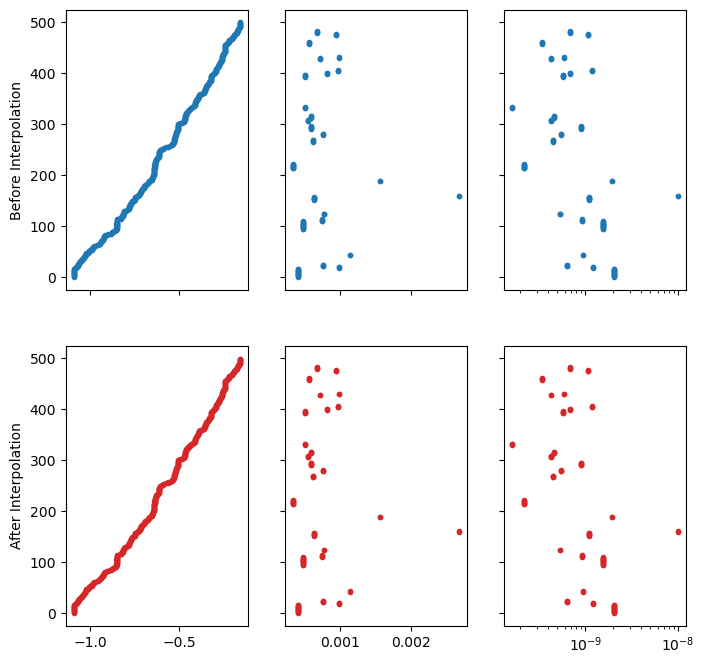

In [25]:
f,ax = plt.subplots(ncols = 3, nrows = 2, sharey = "all", sharex = "col", figsize = (8,8))
print(f"Profile at {current_profile['Longitude'].mean():.1f}")
ax[0,0].plot(current_profile['Temp [°C]'][cut], max_depth - depth, ".", lw = 5)
ax[1,0].plot(T_func(new_mab),new_mab, ".", lw = 5, c = "tab:red")

ax[0,1].plot(N[cut], max_depth - depth, ".", lw = 5)
ax[0,2].semilogx(eps[cut], max_depth - depth, ".", lw = 5)
ax[1,1].plot(N_func(new_mab),new_mab, ".", lw = 5, c = "tab:red")
ax[1,2].semilogx(eps_func(new_mab),new_mab, ".",lw = 5, c = "tab:red",)

ax[0,0].set_ylabel("Before Interpolation")
ax[1,0].set_ylabel("After Interpolation");

In [63]:
#sort columns after their longitude value
eps_df.sort_index(axis=1, inplace=True)
N_df.sort_index(axis=1, inplace=True)
T_df.sort_index(axis=1, inplace=True)

In [64]:
#small data cleaning
try:
    assert T_df.iloc[:,35].count() < 120
    print(f"Profile at {T_df.columns[35]:.1f}°W contains only {T_df.iloc[:,35].count()} values and will be removed")
    eps_df.drop(T_df.columns[35], axis = "columns", inplace = True)
    N_df.drop(T_df.columns[35], axis = "columns", inplace = True)
    T_df.drop(T_df.columns[35], axis = "columns", inplace = True)
except AssertionError:
    pass

In [28]:
K_df = 0.2 * eps_df / (N_df)**2
eps_df.to_csv("./thorpe_eps.csv")
K_df.to_csv("./thorpe_krho.csv")
eps_df.to_pickle("/home/ole/Desktop/Mooring_Analysis/energy_levels/data/Thorpe_eps_df.pkl")
K_df.to_pickle("/home/ole/Desktop/Mooring_Analysis/energy_levels/data/Thorpe_K_df.pkl")
T_df.to_pickle("/home/ole/Desktop/Mooring_Analysis/energy_levels/data/Thorpe_T_df.pkl")
np.savez("/home/ole/Desktop/Mooring_Analysis/energy_levels/data/Thorpe_result", time_stamp = datetime.datetime.now(), mab = new_mab)

In [93]:
_T_df = T_df.drop(T_df.columns[T_df.columns < -51.5], axis = "columns") 
_T_df.drop(_T_df.columns[_T_df.columns > -48.5], axis = "columns", inplace = True) 
vertical_eps_df = eps_df.drop(eps_df.columns[eps_df.columns < -51.5], axis = "columns") 
vertical_eps_df.drop(vertical_eps_df.columns[vertical_eps_df.columns > -48.5], axis = "columns", inplace = True) 

BACKGROUND_DISSIPATION = 1e-10 #https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017GL076269
vertical_eps_df.fillna(value = BACKGROUND_DISSIPATION, inplace = True)
vertical_eps_df.where(cond = ~_T_df.isna(), other = np.nan, inplace = True)
vertical_eps_df

,-51.4560,-51.4005,-51.3833,-51.3667,-51.3477,-51.3462,-51.3063,-51.3010,-51.2950,-51.2095,...,-49.1630,-49.1533,-49.1500,-49.1500,-49.1342,-49.1278,-49.0801,-48.8504,-48.8231,-48.8170
0,1.000000e-10,1.000000e-10,1.000000e-10,1.728876e-08,5.359698e-09,1.306269e-08,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,...,4.107653e-09,1.000000e-10,1.000000e-10,1.000000e-10,1.044748e-08,1.000000e-10,1.901140e-09,1.294769e-08,7.183300e-09,1.000000e-10
1,1.000000e-10,1.000000e-10,1.000000e-10,1.728876e-08,5.359698e-09,1.306269e-08,1.000000e-10,4.839931e-09,1.000000e-10,1.000000e-10,...,4.107653e-09,1.000000e-10,1.000000e-10,1.000000e-10,1.044748e-08,1.000000e-10,1.901140e-09,1.294769e-08,7.183300e-09,1.000000e-10
2,1.000000e-10,1.000000e-10,1.000000e-10,1.728876e-08,5.359698e-09,1.306269e-08,1.000000e-10,4.839931e-09,1.000000e-10,1.000000e-10,...,4.107653e-09,1.000000e-10,1.000000e-10,1.000000e-10,1.044748e-08,1.000000e-10,1.901140e-09,1.294769e-08,7.183300e-09,1.000000e-10
3,1.000000e-10,1.000000e-10,1.000000e-10,1.728876e-08,5.359698e-09,1.306269e-08,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,...,4.107653e-09,1.000000e-10,1.000000e-10,1.000000e-10,1.044748e-08,1.000000e-10,1.901140e-09,1.294769e-08,7.183300e-09,1.000000e-10
4,4.404328e-09,1.000000e-10,1.000000e-10,1.728876e-08,5.359698e-09,1.306269e-08,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,...,4.107653e-09,1.000000e-10,1.000000e-10,1.000000e-10,1.044748e-08,1.000000e-10,1.901140e-09,1.294769e-08,7.183300e-09,1.000000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.000000e-10,2.282153e-09,1.000000e-10,1.641767e-08,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,...,1.000000e-10,2.454727e-08,2.693936e-09,1.000000e-10,1.748134e-09,3.970042e-09,1.000000e-10,1.340409e-09,1.000000e-10,1.000000e-10
496,1.000000e-10,2.282153e-09,1.000000e-10,1.641767e-08,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,...,1.000000e-10,2.454727e-08,2.693936e-09,1.000000e-10,1.748134e-09,3.970042e-09,1.000000e-10,1.340409e-09,1.000000e-10,1.000000e-10
497,1.000000e-10,2.282153e-09,1.000000e-10,1.641767e-08,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,...,1.000000e-10,2.454727e-08,2.693936e-09,1.000000e-10,1.748134e-09,3.970042e-09,1.000000e-10,1.340409e-09,1.000000e-10,1.000000e-10
498,1.000000e-10,2.282153e-09,1.000000e-10,1.641767e-08,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,...,1.000000e-10,2.454727e-08,2.693936e-09,1.000000e-10,1.748134e-09,3.970042e-09,1.000000e-10,1.340409e-09,1.000000e-10,1.000000e-10


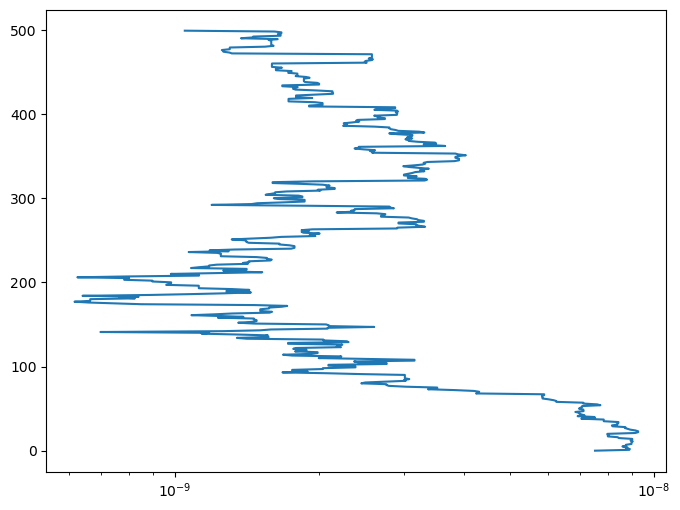

In [99]:
fig,ax = plt.subplots(1)
mean = vertical_eps_df.mean(axis = 1)
std = vertical_eps_df.std(axis = 1)
"""
column_number = len(vertical_eps_df.columns)
n = 3
outliers = (vertical_eps_df > np.tile(mean+n*std, (column_number,1)).T) | (vertical_eps_df < np.tile(_mean-n*_std, (column_number,1)).T)
# Set outliers to NaN
_vertical_eps_df = vertical_eps_df.copy(deep = True)
_vertical_eps_df[outliers] = pd.NA
# Calculate new mean, ignoring NaNs
_mean = _vertical_eps_df.mean(axis = 1)
_std = _vertical_eps_df.std(axis = 1)
"""
#ax.fill_betweenx(vertical_eps_df.index, _mean-_std, _mean+_std, alpha = 0.5 )
ax.semilogx(mean, vertical_eps_df.index)
#ax.semilogx(mean, _vertical_eps_df.index)

In [100]:
np.savez("./Thorpe_vertical_eps", z = vertical_eps_df.index, eps = mean)

## Plot dataframe as 2D plot and improve the figure

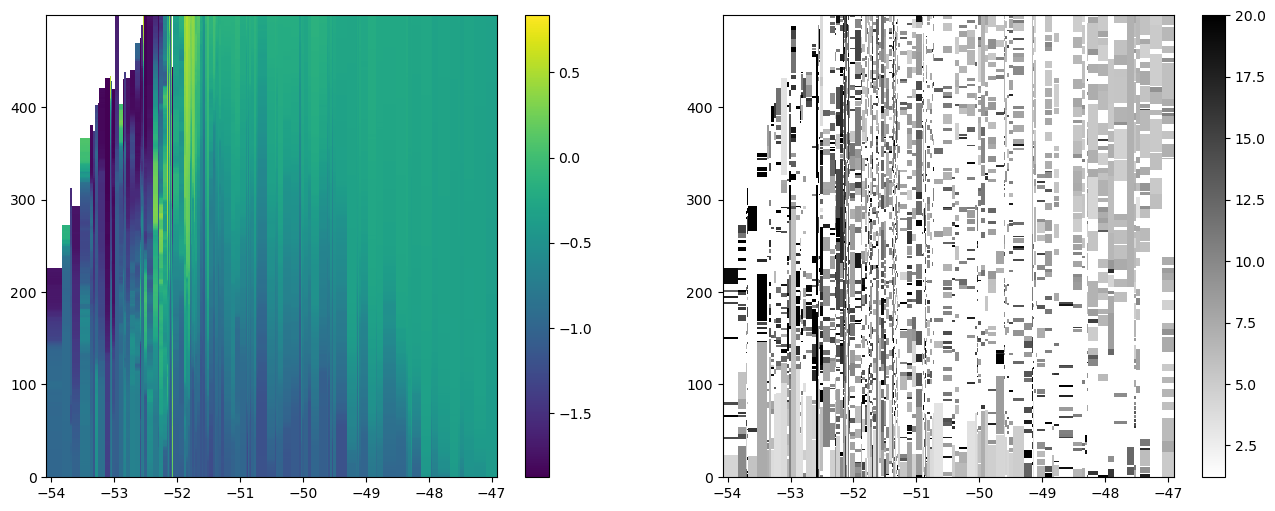

In [37]:
f,a = plt.subplots(ncols = 2, figsize = (16,6))
cb = a[0].pcolormesh(T_df.columns, new_mab, T_df, cmap = "viridis")
plt.colorbar(cb, ax = a[0])
cb = a[1].pcolormesh(N_df.columns, new_mab, N_df* 86400 / (2 * np.pi), vmax = 20, cmap = "gray_r")
plt.colorbar(cb, ax = a[1])

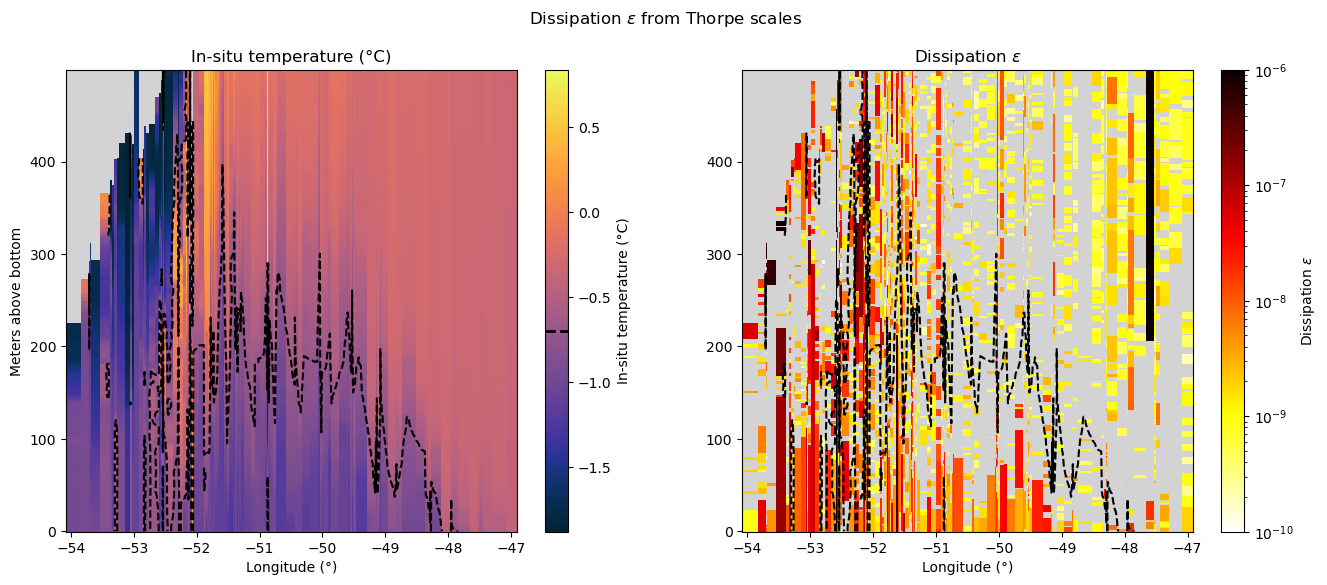

In [38]:
f, a = plt.subplots(ncols=2, figsize=(16, 6), sharex=True)
mpp = a[0].pcolormesh(
    T_df.columns, 
    new_mab, 
    T_df, 
    cmap=cmocean.cm.thermal
)
cb = plt.colorbar(mpp, ax=a[0])
a[0].contour(
    T_df.columns, 
    new_mab, 
    T_df, 
    levels=[-0.7], 
    colors="k"
)
cb.ax.plot([0, 1], [-0.7, -0.7], "k--", lw=2)
a[0].set_facecolor("lightgrey")
cb.set_label(r"In-situ temperature (°C)")
a[0].set_ylabel("Meters above bottom")
a[0].set_xlabel("Longitude (°)")
a[0].set_title(r"In-situ temperature (°C)")

mpp = a[1].pcolormesh(
    eps_df.columns,
    new_mab,
    eps_df,
    norm=mcolors.LogNorm(vmin=1e-10, vmax=1e-6),
    cmap="hot_r",
)
cb = plt.colorbar(mpp, ax=a[1])
cb.set_label(r"Dissipation $\varepsilon$")
a[1].contour(
    T_df.columns, 
    new_mab, 
    T_df, 
    levels=[-0.7], 
    colors="k"
)
a[1].set_facecolor("lightgrey")
a[1].set_xlabel("Longitude (°)")
a[1].set_title(r"Dissipation $\varepsilon$")
f.suptitle(r"Dissipation $\varepsilon$ from Thorpe scales")
f.savefig("./ThorpeDissipation.png", dpi=300)

# Bin averaging

Use $K_\rho = \gamma \epsilon / N^2$ to calculate the diffusivity

In [39]:
K_df = 0.2 * eps_df / (N_df)**2

In [40]:
print(f"Max = {K_df.max(axis = None):.1e}, Min = {K_df.min(axis = None):.1e}")

Max = 7.7e+00, Min = 2.5e-05


In [41]:
# add background diffusivity, but not where there is no temperature data
BACKGROUND_DIFFUSIVITY = 1e-5 #https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017GL076269
K_df.fillna(value = BACKGROUND_DIFFUSIVITY, inplace = True)
K_df.where(cond = ~T_df.isna(), other = np.nan, inplace = True)
K_df.where(cond = K_df < 1, other = np.nan, inplace = True) # values too large are cut

BACKGROUND_DISSIPATION = 1e-10 #https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017GL076269
eps_df.fillna(value = BACKGROUND_DISSIPATION, inplace = True)
eps_df.where(cond = ~T_df.isna(), other = np.nan, inplace = True)

In [42]:
print(f"Max = {K_df.max(axis = None):.1e}, Min = {K_df.min(axis = None):.1e}")

Max = 5.4e-01, Min = 1.0e-05


In [43]:
lons = K_df.columns.to_numpy()
max_lon = max(lons)
min_lon = min(lons)
NUMBER_OF_BINS = 15
BIN_EDGES = np.linspace(min_lon-1e-3*min_lon, max_lon+1e-3*max_lon, NUMBER_OF_BINS + 1)

In [44]:
import scipy.stats as ss

All values are arithmically averaged

In [45]:
lons = K_df.columns.to_numpy()
rows = []
for index, row in K_df.iterrows():
    values = row.to_numpy()
    bin_means= ss.binned_statistic(x = lons, values = values, statistic=np.nanmean, bins = BIN_EDGES)[0]
    new_K = bin_means
    new_row = pd.DataFrame([new_K], columns = BIN_EDGES[:-1])
    rows.append(new_row)
binned_K_df = pd.concat(rows, sort = False).reset_index(drop = True)
    
#binned_K_df = binned_K_df.append(other = new_row, ignore_index=True)


rows = []
for index, row in T_df.iterrows():
    values = row.to_numpy()
    bin_means= ss.binned_statistic(x = lons, values = values, statistic=np.nanmean, bins = BIN_EDGES)[0]
    new_row = pd.DataFrame([bin_means], columns = BIN_EDGES[:-1])
    rows.append(new_row)

binned_T_df = pd.concat(rows, sort = False).reset_index(drop = True)

rows = []
for index, row in eps_df.iterrows():
    values = row.to_numpy()
    bin_means= ss.binned_statistic(x = lons, values = values, statistic=np.nanmean, bins = BIN_EDGES)[0]
    new_eps = bin_means
    new_row = pd.DataFrame([new_eps], columns = BIN_EDGES[:-1])
    rows.append(new_row)
binned_eps_df = pd.concat(rows, sort = False).reset_index(drop = True)
binned_eps_df.to_csv("./binned_thorpe_eps.csv")

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

In [46]:
binned_K_df

,-53.901045,-53.444115,-52.987186,-52.530256,-52.073326,-51.616397,-51.159467,-50.702537,-50.245608,-49.788678,-49.331748,-48.874819,-48.417889,-47.960959,-47.504030
0,0.01197,0.039936,0.054000,0.016627,0.021246,0.021756,0.016547,0.003096,0.019934,0.009184,0.005245,0.002048,0.000343,0.001386,0.000133
1,0.01197,0.039936,0.058253,0.016627,0.021246,0.023037,0.018277,0.003147,0.019934,0.009184,0.005286,0.002350,0.000343,0.001386,0.000133
2,0.01197,0.039936,0.058253,0.016627,0.021274,0.023049,0.018277,0.003508,0.019934,0.009184,0.005286,0.002350,0.000485,0.001386,0.000133
3,0.01197,0.039936,0.058253,0.016615,0.021274,0.023034,0.018555,0.003895,0.019934,0.010317,0.005286,0.002350,0.000415,0.001615,0.000133
4,0.01185,0.039936,0.058253,0.016615,0.021274,0.023217,0.018555,0.003895,0.019934,0.010317,0.005286,0.002350,0.000425,0.001615,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,0.001534,0.005266,0.006075,0.001867,0.000295,0.000010,0.001662,0.000137,0.003675,0.000415,0.000840,0.000657,0.001513
496,NaN,NaN,0.001534,0.005253,0.005965,0.001409,0.000250,0.000099,0.001662,0.000358,0.003647,0.000415,0.000840,0.000657,0.001513
497,NaN,NaN,0.001592,0.005191,0.005983,0.001623,0.000278,0.000099,0.001662,0.000385,0.003647,0.000415,0.000840,0.000489,0.001858
498,NaN,NaN,0.002546,0.005191,0.006009,0.001557,0.000172,0.000102,0.001662,0.000385,0.003647,0.000415,0.000710,0.000489,0.001858


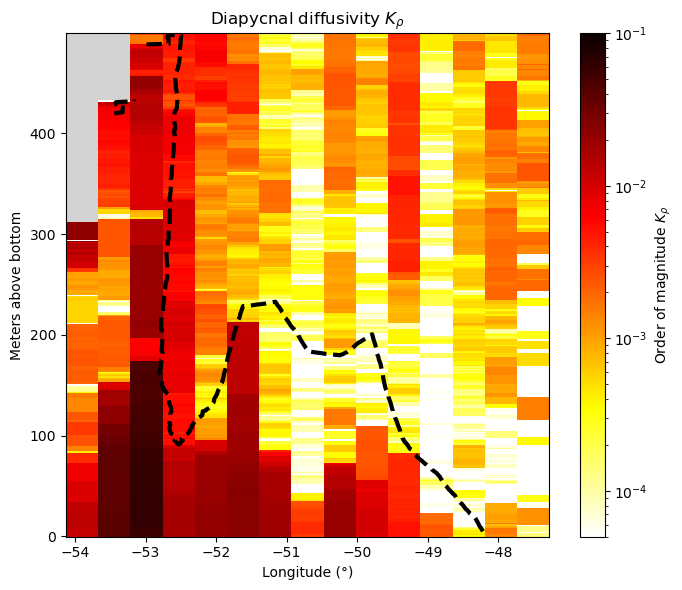

In [47]:
f,a = plt.subplots(nrows = 1, figsize = (7,6), sharex = True)

norm = mcolors.LogNorm(vmin = 5e-5, vmax = 1e-1)
mpp = a.pcolormesh(
    binned_K_df.columns, 
    new_mab, 
    binned_K_df,
    norm = norm, 
    cmap = "hot_r",
)

a.set_facecolor('lightgrey')
cb = plt.colorbar(mpp, ax = a)
cb.set_label(r"Order of magnitude $K_\rho$")
a.set_xlabel("Longitude (°)")
a.set_title(r"Diapycnal diffusivity $K_\rho$")
a.contour(
    binned_T_df.columns, 
    new_mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)
a.set_ylabel("Meters above bottom")
f.tight_layout()
#f.savefig("./Thorpe_Poster.png", dpi = 800)

## Use $K_\rho = \gamma \epsilon / N^2$ to calculate the diffusivity

In [48]:
#K_df = 0.2 * eps_df / (N_df)**2

# Final Summary Figure

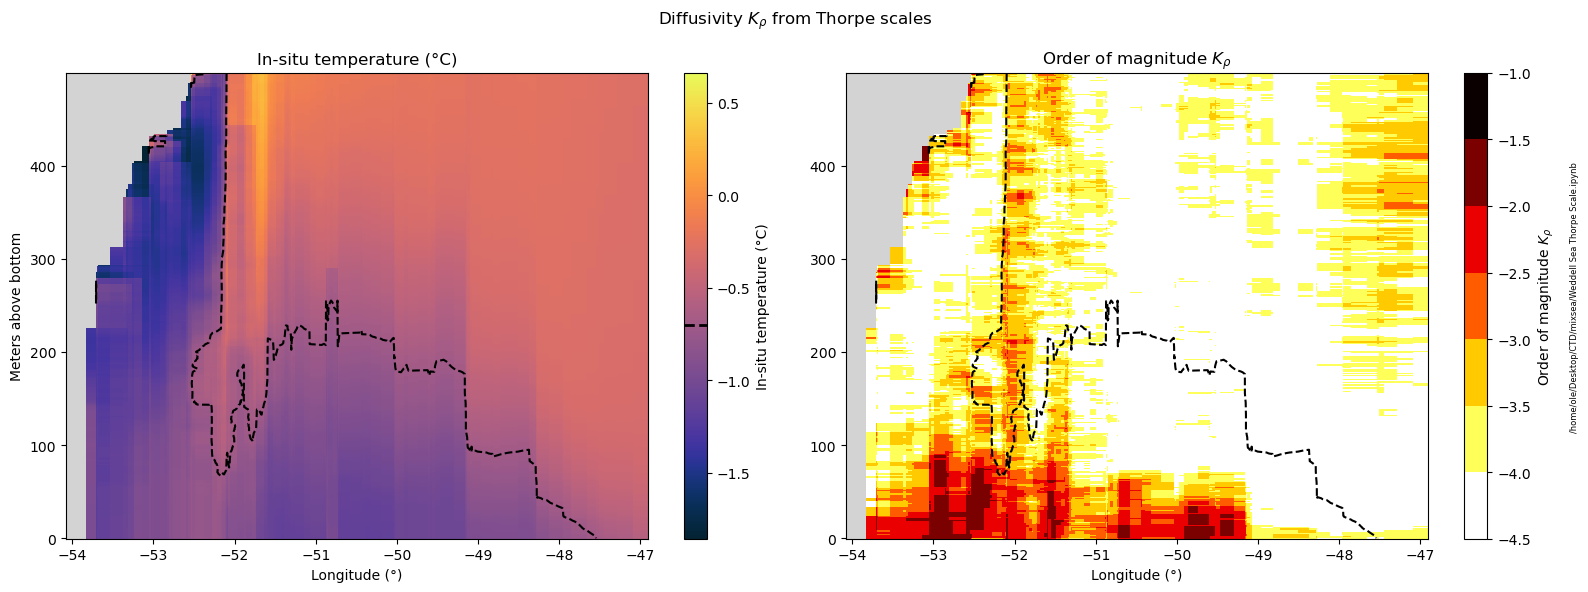

In [49]:
f,a = plt.subplots(ncols = 2, figsize = (16,6), sharex = True)
mpp = a[0].pcolormesh(T_df.columns, new_mab, T_df.rolling(10,axis = 1,min_periods=2).mean(), cmap = cmocean.cm.thermal)
cb = plt.colorbar(mpp, ax = a[0])
a[0].contour(T_df.columns, new_mab, T_df.rolling(10,axis = 1,min_periods=2).mean(), levels = [-0.7], colors = "k")
cb.ax.plot([0, 1], [-0.7,-0.7], 'k--', lw = 2)
a[0].set_facecolor('lightgrey')
cb.set_label(r"In-situ temperature (°C)")
a[0].set_ylabel("Meters above bottom")
a[0].set_xlabel("Longitude (°)")
a[0].set_title(r"In-situ temperature (°C)")

cmap = plt.cm.viridis
bounds = np.arange(-4.5,-0.5,0.5)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
mpp = a[1].pcolormesh(K_df.columns, new_mab, np.log10(K_df).rolling(10,axis = 1,min_periods=2).mean(), norm = norm, cmap = "hot_r")
a[1].set_facecolor('lightgrey')
cb = plt.colorbar(mpp, ax = a[1])
cb.set_label(r"Order of magnitude $K_\rho$")
a[1].set_xlabel("Longitude (°)")
a[1].set_title(r"Order of magnitude $K_\rho$")
a[1].contour(T_df.columns, new_mab, T_df.rolling(10,axis = 1,min_periods=2).mean(), levels = [-0.7], colors = "k")#, linewidths = 4)
helper.Plot.path_as_footnote(fig = f, 
                             path = "/home/ole/Desktop/CTD/mixsea/Weddell Sea Thorpe Scale.ipynb", 
                             rot = "vertical")
f.suptitle(r"Diffusivity $K_\rho$ from Thorpe scales")
f.tight_layout()
f.savefig("./ThorpeDiffusivity.png", dpi = 300)

# Combination of T, $\varepsilon$ and $K_\rho$

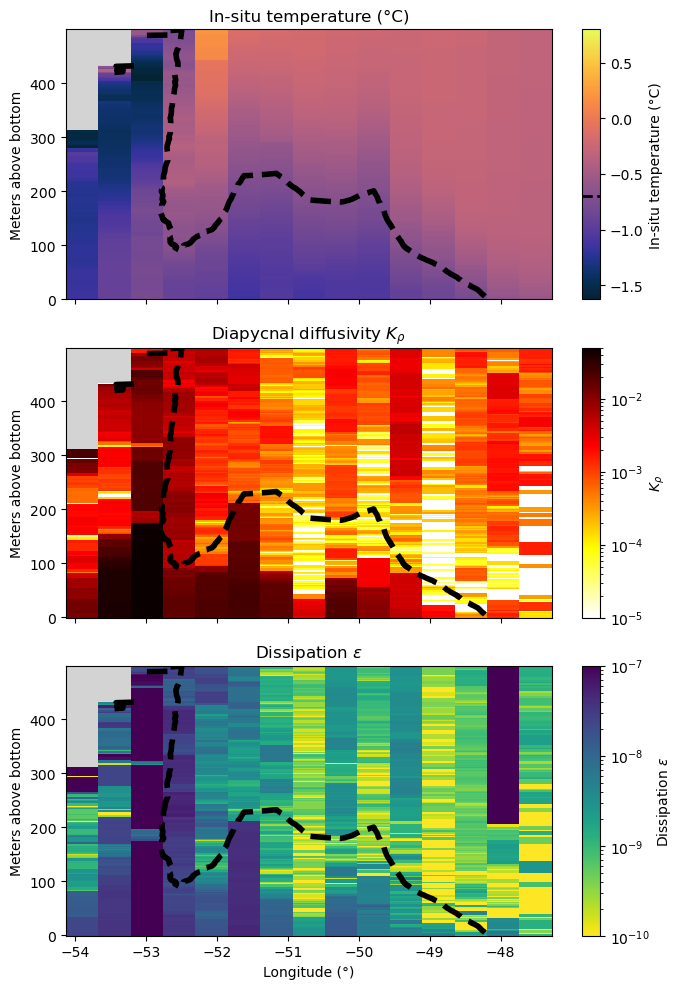

In [50]:
f,a = plt.subplots(nrows = 3, figsize = (7,10), sharex = True)
mpp = a[0].pcolormesh(
    binned_T_df.columns, 
    new_mab, 
    binned_T_df,
    cmap = cmocean.cm.thermal,
)

cb = plt.colorbar(mpp, ax = a[0], aspect=15)
a[0].contour(
    binned_T_df.columns,
    new_mab,
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 4,
)

cb.ax.plot([0, 1], [-0.7,-0.7], 'k--', lw = 2)
a[0].set_facecolor('lightgrey')
cb.set_label(r"In-situ temperature (°C)")
a[0].set_ylabel("Meters above bottom")
#a[0].set_xlabel("Longitude (°)")
a[0].set_title(r"In-situ temperature (°C)")

cmap = plt.cm.viridis
bounds = np.arange(-3,1,0.5)
#norm = mcolors.BoundaryNorm(bounds, cmap.N)
#mpp = a[1].pcolormesh(K_df.columns, new_mab, np.logWINDOW_SIZE(K_df), norm = norm, cmap = "viridis")
#norm = mcolors.LogNorm(vmin = 5e-4, vmax = 1)
vmin = BACKGROUND_DIFFUSIVITY
vmax = 5e-2
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = a[1].pcolormesh(
    binned_K_df.columns, 
    new_mab, 
    binned_K_df,
    norm = norm, 
    cmap = "hot_r",
)

a[1].set_facecolor('lightgrey')
a[1].set_ylabel("Meters above bottom")
cb = plt.colorbar(mpp, ax = a[1], aspect=15)
cb.set_label(r"$K_\rho$")
#a[1].set_xlabel("Longitude (°)")
a[1].set_title(r"Diapycnal diffusivity $K_\rho$")
a[1].contour(
    binned_T_df.columns, 
    new_mab, 
    binned_T_df, 
    levels = [-0.7],
    colors = "k",
    linewidths = 4,
)

vmin = BACKGROUND_DISSIPATION
vmax = 1e-7
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = a[2].pcolormesh(
    binned_eps_df.columns, 
    new_mab, 
    binned_eps_df,
    norm= norm, 
    cmap = "viridis_r",
)
cb = plt.colorbar(mpp, ax = a[2], aspect=15)
cb.set_label(r"Dissipation $\varepsilon$")
a[2].contour(
    binned_T_df.columns, 
    new_mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 4,
)
a[2].set_facecolor('lightgrey')
a[2].set_xlabel("Longitude (°)")
a[2].set_title(r"Dissipation $\varepsilon$")
a[2].set_ylabel("Meters above bottom")

#helper.Plot.path_as_footnote(fig = f, 
#                             path = "/home/ole/Desktop/CTD/mixsea/Weddell Sea Thorpe Scale.ipynb", 
#                             rot = "vertical")
#f.suptitle(r"Diffusivity $K_\rho$ from Thorpe scales")
f.tight_layout()
f.savefig("./ThorpeSummary.png", dpi = 300)

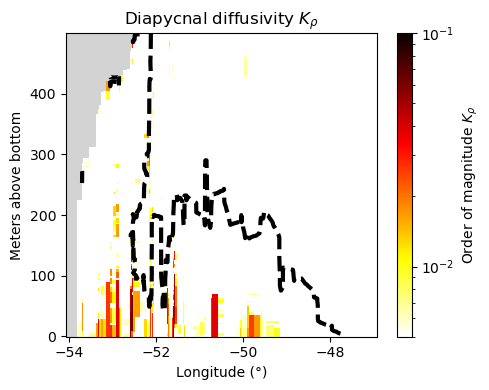

In [51]:
WINDOW_SIZE = 6
MIN_PERIODS = 3

f,a = plt.subplots(nrows = 1, figsize = (5,4), sharex = True)

norm = mcolors.LogNorm(vmin = 5e-3, vmax = 1e-1)
mpp = a.pcolormesh(
    K_df.columns, 
    new_mab, 
    np.power(10,np.log10(K_df).rolling(3,axis = 1, min_periods=2).mean()),
    norm = norm, 
    cmap = "hot_r",
)

a.set_facecolor('lightgrey')
cb = plt.colorbar(mpp, ax = a)
cb.set_label(r"Order of magnitude $K_\rho$")
a.set_xlabel("Longitude (°)")
a.set_title(r"Diapycnal diffusivity $K_\rho$")
a.contour(
    T_df.columns, 
    new_mab, 
    T_df.rolling(WINDOW_SIZE,axis = 1,min_periods=MIN_PERIODS).mean(), 
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)
a.set_ylabel("Meters above bottom")
f.tight_layout()
f.savefig("./Thorpe_Poster.png", dpi = 800)
K_df.to_pickle("/home/ole/Desktop/Mooring_Analysis/energy_levels/data/Thorpe_K_df.pkl")
T_df.to_pickle("/home/ole/Desktop/Mooring_Analysis/energy_levels/data/Thorpe_T_df.pkl")
np.savez("/home/ole/Desktop/Mooring_Analysis/energy_levels/data/Thorpe_result", time_stamp = datetime.datetime.now(), mab = new_mab)

# Differentiated after each expedition

In [52]:
DENSITY_NOISE = 3e-4  # Noise parameter
ALPHA = 0.8  # Coefficient relating the Thorpe and Ozmidov scales.
# Background value of epsilon applied where no overturns are detected.
background_eps = np.nan

In [53]:
CTDs["Expedition"]

0         PS129
1         PS129
2         PS129
3         PS129
4         PS129
          ...  
281749    PS117
281750    PS117
281751    PS117
281752    PS117
281753    PS117
Name: Expedition, Length: 281754, dtype: category
Categories (12, object): ['PS103', 'PS117', 'PS129', 'PS16', ..., 'PS67', 'PS71', 'PS77', 'PS81']

In [54]:
CTDs_grouped = CTDs.groupby("Expedition")
expedition_names = CTDs_grouped.groups.keys()
print(expedition_names)

dict_keys(['PS103', 'PS117', 'PS129', 'PS16', 'PS18', 'PS23', 'PS40', 'PS49', 'PS67', 'PS71', 'PS77', 'PS81'])


PS103
PS117
	PS117_66-4 is too shallow
PS129
PS16
PS18
	PS18/045-2 bottom temperatures are too high
PS23
	PS23/061-1 only produces NaNs
PS40
	PS40/098-1 only produces NaNs
	PS40/099-1 only produces NaNs
	PS40/099-4 only produces NaNs
	PS40/100-1 only produces NaNs
	PS40/101-1 only produces NaNs
	PS40/102-2 only produces NaNs
PS49
	PS49/015-2 bottom temperatures are too high
	PS49/017-1 only produces NaNs
PS67
PS71
	PS71/209-1 only produces NaNs
	PS71/210-1 is too shallow
	PS71/210-2 is too shallow
	PS71/210-3 only produces NaNs
	PS71/211-1 only produces NaNs
	PS71/212-1 only produces NaNs
	PS71/212-3 bottom temperatures are too high
	PS71/216-4 only produces NaNs
PS77
	PS77/105-3 only produces NaNs
PS81
	PS81/101-1 only produces NaNs
	PS81/102-1 only produces NaNs


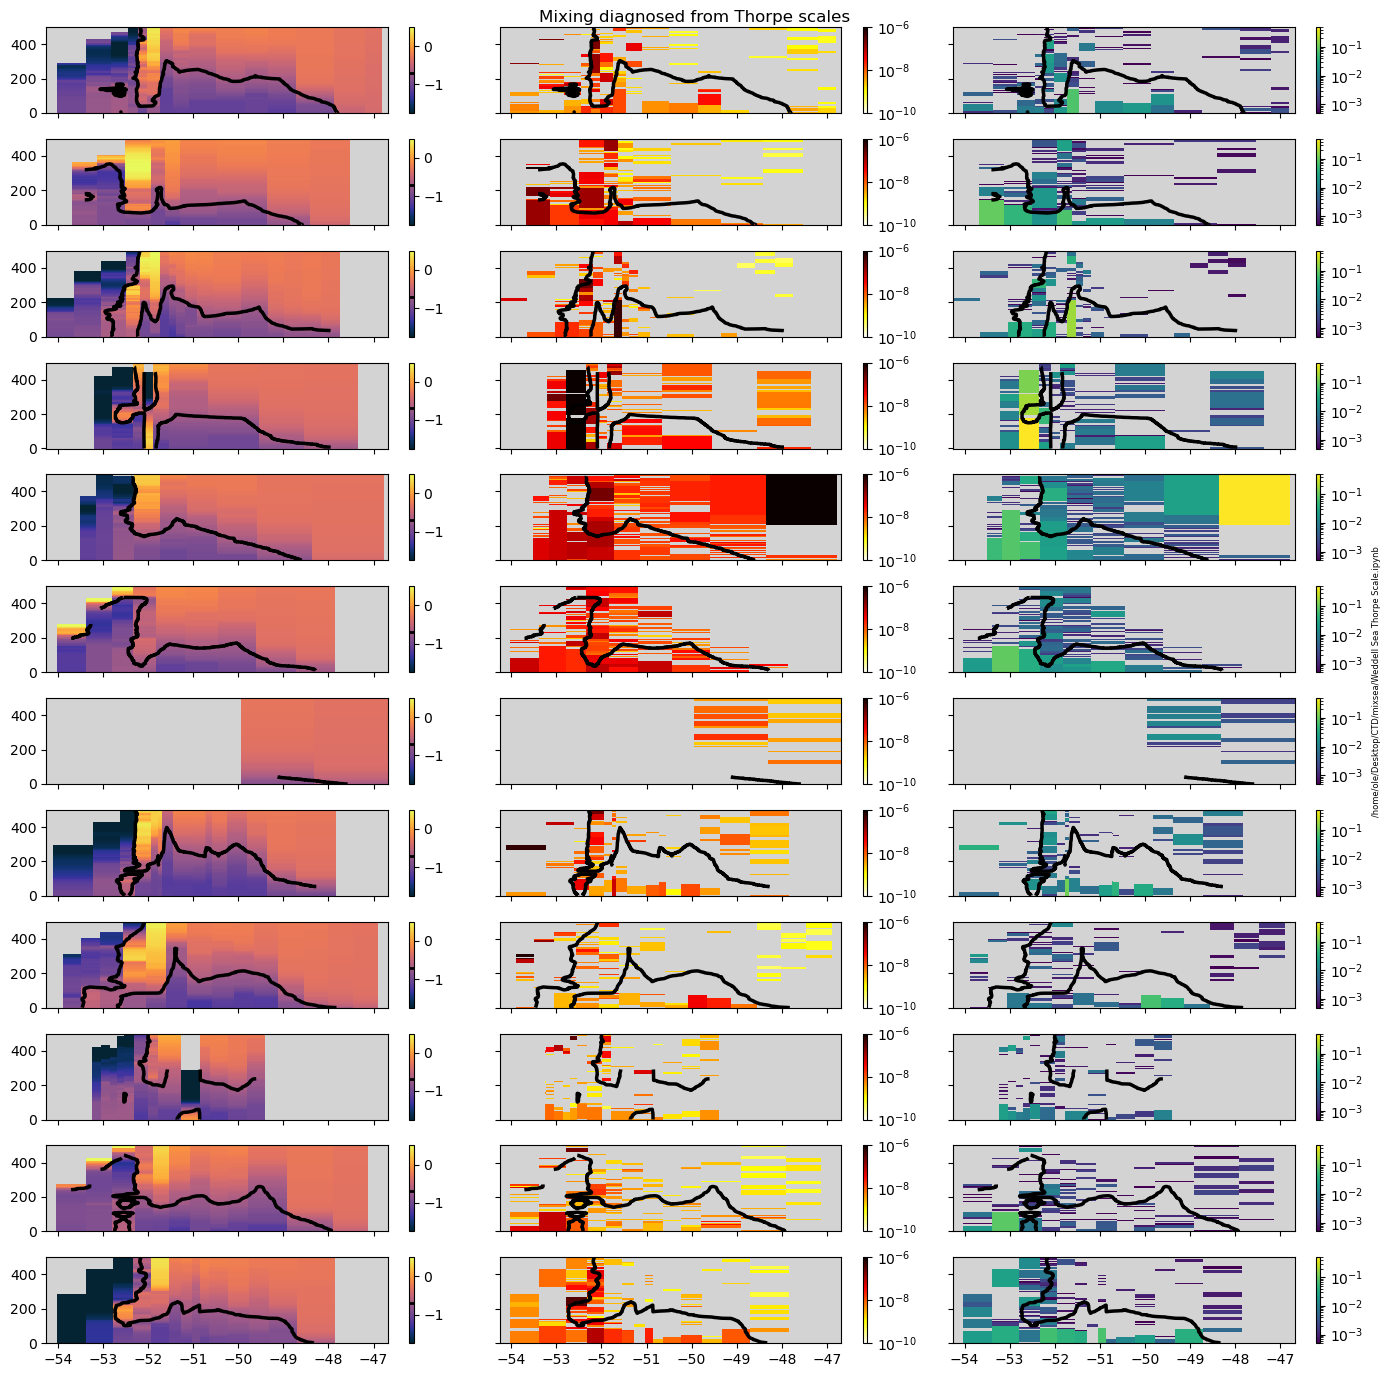

In [55]:
# define a common axis with grid spacing of 1
new_mab = np.arange(0,500,1)
        
f,a = plt.subplots(nrows = len(expedition_names), ncols = 3, sharex = True, sharey = True, figsize = (14,14))

for i, name in enumerate(expedition_names):
    print(name)
    
    # objects for saving the data later    
    eps_df = pd.DataFrame()
    N_df = pd.DataFrame()
    T_df = pd.DataFrame()

    expedition = CTDs_grouped.get_group(name).reset_index(drop = True)
    expedition = expedition.groupby("Event")
    events = expedition.groups.keys()
    
    for event in events:
        if name not in event: continue
            
        current_profile = expedition.get_group(event).reset_index(drop = True)

        eps, N2_in_radians = mx.overturn.eps_overturn(
            current_profile['Depth water [m]'],
            current_profile['Temp [°C]'],
            current_profile['Sal'],
            current_profile["Longitude"].mean(),
            current_profile["Latitude"].mean(),
            dnoise=DENSITY_NOISE,
            alpha=ALPHA,
            background_eps=background_eps,
        )

        N = np.sqrt(N2_in_radians)
        #N_in_cpd = np.sqrt(N2_in_radians) * 86400 / (2 * np.pi) # Calculate buoyancy frequency in units of cycles per day (cpd).

        # Plot only in the depth range:
        max_depth = current_profile['Depth water [m]'].max()
        cut = current_profile['Depth water [m]'] > ( max_depth - 500 )
        depth = current_profile['Depth water [m]'][cut]

        if np.all(np.isnan(N[cut])):
            print(f"\t{event} only produces NaNs")
            continue
        if max_depth < 200:
            print(f"\t{event} is too shallow")
            continue    
        if current_profile['Temp [°C]'].iloc[-1] > 0.2:
            print(f"\t{event} bottom temperatures are too high")
            continue
        

        # nearest interpolation to the defined axis
        N_func = interp1d(max_depth - depth, N[cut], kind='nearest', bounds_error = False, fill_value=(np.nan, np.nan))
        eps_func = interp1d(max_depth - depth, eps[cut], kind='nearest', bounds_error = False, fill_value=(np.nan, np.nan))
        T_func = interp1d(max_depth - depth, current_profile['Temp [°C]'][cut], kind='nearest', bounds_error = False, fill_value=(np.nan, np.nan))

        N_df[current_profile["Longitude"].mean()] = N_func(new_mab)
        eps_df[current_profile["Longitude"].mean()] = eps_func(new_mab)
        T_df[current_profile["Longitude"].mean()] = T_func(new_mab)
        

    #sort columns after their longitude value
    eps_df.sort_index(axis=1, inplace=True)
    N_df.sort_index(axis=1, inplace=True)
    T_df.sort_index(axis=1, inplace=True)
    K_df = 0.2 * eps_df / N_df**2

    mpp = a[i,0].pcolormesh(T_df.columns, new_mab, T_df, cmap = cmocean.cm.thermal, vmax = 0.5, vmin = -1.75)
    cb = plt.colorbar(mpp, ax = a[i,0])
    a[i,0].contour(T_df.columns, new_mab, T_df, levels = [-0.7], 
                   colors = "k", linewidths = 2.5, negative_linestyles ='solid')
    cb.ax.plot([0, 1], [-0.7,-0.7], 'k--', lw = 2)
    a[i,0].set_facecolor('lightgrey')
    #cb.set_label(r"In-situ temperature (°C)")
    #a[i,0].set_ylabel("Meters above bottom")
    #a[i,0].set_xlabel("Longitude (°)")
    #a[i,0].set_title(r"In-situ temperature (°C)")


    #cmap = plt.cm.get_cmap("hot_r")
    #cmap.set_bad(color='lightgrey')
    mpp = a[i,1].pcolormesh(eps_df.columns, new_mab, eps_df, norm=  mcolors.LogNorm(vmin = 1e-10, vmax = 1e-6), cmap = "hot_r")
    cb = plt.colorbar(mpp, ax = a[i,1])
    #cb.set_label(r"Dissipation $\varepsilon$")
    a[i,1].contour(T_df.columns, new_mab, T_df, levels = [-0.7], 
                   colors = "k", linewidths = 2.5, negative_linestyles ='solid')
    a[i,1].set_facecolor('lightgrey')
    #a[i,1].set_xlabel("Longitude (°)")
    #a[i,1].set_title(r"Dissipation $\varepsilon$")

    #cmap = plt.cm.viridis
    #bounds = np.arange(-4.5,-0.5,0.5)
    #mpp = a[1].pcolormesh(K_df.columns, new_mab, np.log10(K_df), norm = norm, cmap = "viridis")
    norm = mcolors.LogNorm(vmin = 5e-4, vmax = 0.5)
    mpp = a[i,2].pcolormesh(K_df.columns, new_mab, K_df, norm = norm, cmap = "viridis")
    a[i,2].set_facecolor('lightgrey')
    cb = plt.colorbar(mpp, ax = a[i,2])
    #cb.set_label(r"Order of magnitude $K_\rho$")
    #a[i,2].set_xlabel("Longitude (°)")
    #a[i,2].set_title(r"Diapycnal diffusivity $K_\rho$")
    a[i,2].contour(T_df.columns, new_mab, T_df, levels = [-0.7], 
                   colors = "k", linewidths = 2.5, negative_linestyles ='solid')
    
f.suptitle(r"Mixing diagnosed from Thorpe scales")
helper.Plot.path_as_footnote(fig = f, 
                             path = "/home/ole/Desktop/CTD/mixsea/Weddell Sea Thorpe Scale.ipynb", 
                             rot = "vertical")
f.tight_layout()
#f.savefig("./ThorpeDissipation_individ_Cruises.png", dpi = 300)

PS103
PS117
	PS117_66-4 is too shallow
PS129
PS16
PS18
	PS18/045-2 bottom temperatures are too high
PS23
	PS23/061-1 only produces NaNs
PS40
	PS40/098-1 only produces NaNs
	PS40/099-1 only produces NaNs
	PS40/099-4 only produces NaNs
	PS40/100-1 only produces NaNs
	PS40/101-1 only produces NaNs
	PS40/102-2 only produces NaNs
PS49
	PS49/015-2 bottom temperatures are too high
	PS49/017-1 only produces NaNs
PS67
PS71
	PS71/209-1 only produces NaNs
	PS71/210-1 is too shallow
	PS71/210-2 is too shallow
	PS71/210-3 only produces NaNs
	PS71/211-1 only produces NaNs
	PS71/212-1 only produces NaNs
	PS71/212-3 bottom temperatures are too high
	PS71/216-4 only produces NaNs
PS77
	PS77/105-3 only produces NaNs
PS81
	PS81/101-1 only produces NaNs
	PS81/102-1 only produces NaNs


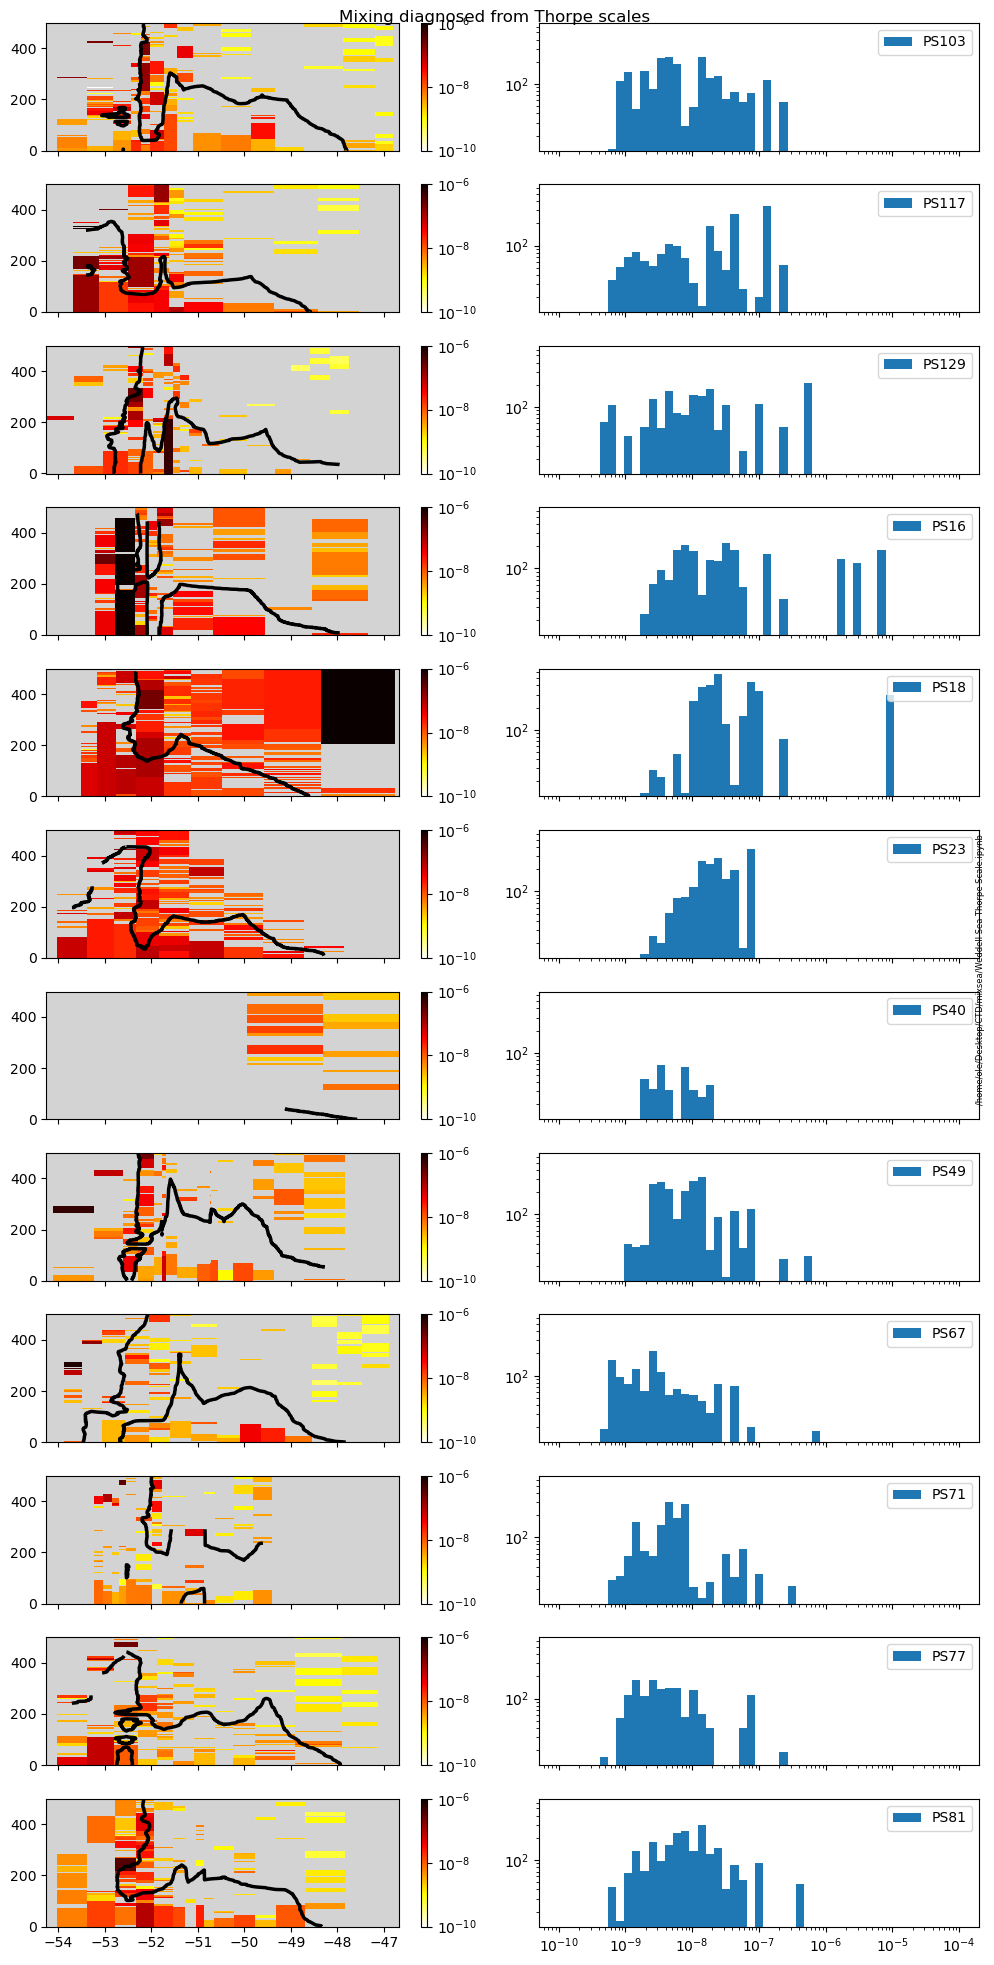

In [56]:
# define a common axis with grid spacing of 1
new_mab = np.arange(0,500,1)
        
f,a = plt.subplots(nrows = len(expedition_names), ncols = 2, sharex = "col", sharey = "col", figsize = (10,20))

for i, expedition_name in enumerate(expedition_names):
    print(expedition_name)
    
    # objects for saving the data later    
    eps_df = pd.DataFrame()
    N_df = pd.DataFrame()
    T_df = pd.DataFrame()

    expedition = CTDs_grouped.get_group(expedition_name).reset_index(drop = True)
    expedition = expedition.groupby("Event")
    events = expedition.groups.keys()
    
    for event in events:
        if expedition_name not in event: continue
            
        current_profile = expedition.get_group(event).reset_index(drop = True)

        eps, N2_in_radians = mx.overturn.eps_overturn(
            current_profile['Depth water [m]'],
            current_profile['Temp [°C]'],
            current_profile['Sal'],
            current_profile["Longitude"].mean(),
            current_profile["Latitude"].mean(),
            dnoise=DENSITY_NOISE,
            alpha=ALPHA,
            background_eps=background_eps,
        )

        N = np.sqrt(N2_in_radians)
        #N_in_cpd = np.sqrt(N2_in_radians) * 86400 / (2 * np.pi) # Calculate buoyancy frequency in units of cycles per day (cpd).

        # Plot only in the depth range:
        max_depth = current_profile['Depth water [m]'].max()
        cut = current_profile['Depth water [m]'] > ( max_depth - 500 )
        depth = current_profile['Depth water [m]'][cut]

        if np.all(np.isnan(N[cut])):
            print(f"\t{event} only produces NaNs")
            continue
        if max_depth < 200:
            print(f"\t{event} is too shallow")
            continue    
        if current_profile['Temp [°C]'].iloc[-1] > 0.2:
            print(f"\t{event} bottom temperatures are too high")
            continue
        

        # nearest interpolation to the defined axis
        N_func = interp1d(max_depth - depth, N[cut], kind='nearest', bounds_error = False, fill_value=(np.nan, np.nan))
        eps_func = interp1d(max_depth - depth, eps[cut], kind='nearest', bounds_error = False, fill_value=(np.nan, np.nan))
        T_func = interp1d(max_depth - depth, current_profile['Temp [°C]'][cut], kind='nearest', bounds_error = False, fill_value=(np.nan, np.nan))

        N_df[current_profile["Longitude"].mean()] = N_func(new_mab)
        eps_df[current_profile["Longitude"].mean()] = eps_func(new_mab)
        T_df[current_profile["Longitude"].mean()] = T_func(new_mab)
        

    #sort columns after their longitude value
    eps_df.sort_index(axis=1, inplace=True)
    N_df.sort_index(axis=1, inplace=True)
    T_df.sort_index(axis=1, inplace=True)
    K_df = 0.2 * eps_df / N_df**2

    mpp = a[i,0].pcolormesh(eps_df.columns, new_mab, eps_df, norm=  mcolors.LogNorm(vmin = 1e-10, vmax = 1e-6), cmap = "hot_r")
    cb = plt.colorbar(mpp, ax = a[i,0])
    #cb.set_label(r"Dissipation $\varepsilon$")
    a[i,0].contour(T_df.columns, new_mab, T_df, levels = [-0.7], 
                   colors = "k", linewidths = 2.5, negative_linestyles ='solid')
    a[i,0].set_facecolor('lightgrey')
    #a[i,1].set_xlabel("Longitude (°)")
    #a[i,1].set_title(r"Dissipation $\varepsilon$")

    eps = eps_df.to_numpy().flatten()
    logbins = np.logspace(-10,-4,50)
    a[i,1].hist(eps, bins=logbins, label = expedition_name)
    a[i,1].set_xscale('log')
    a[i,1].set_yscale('log')
    a[i,1].legend(loc = "upper right")
    
f.suptitle(r"Mixing diagnosed from Thorpe scales")
helper.Plot.path_as_footnote(fig = f, 
                             path = "/home/ole/Desktop/CTD/mixsea/Weddell Sea Thorpe Scale.ipynb", 
                             rot = "vertical")
f.tight_layout()
#f.savefig("./ThorpeDissipation_individ_Cruises.png", dpi = 300)